## Libraries

In [166]:
# General, Text, and Word Parsing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import warnings
import nltk
from nltk.corpus import stopwords
from langdetect import detect
import string
import re
from wordcloud import WordCloud
from os import path
from PIL import Image

# Model Libraries
import sys
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

## Load in Data

In [167]:
lines = []
with open('yelp_academic_dataset_review.json') as file:
    for i, l in enumerate(file):
        lines.append(json.loads(l))
        if i + 1 >= 1000:
            break
data = pd.DataFrame(lines)

## Exploratory Data Analysis

#### Print out the data's first few values and other summary stats

In [168]:
print(f"{data.head()}\n\n")
print(data.info())

                review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2  saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4  Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   

   stars  useful  funny  cool  \
0    3.0       0      0     0   
1    5.0       1      0     1   
2    3.0       0      0     0   
3    5.0       1      0     1   
4    4.0       1      0     1   

                                                text                 date  
0  If you decide to eat here, just be aware it is...  2018-07-07 22:09:11  
1  I've taken a lot of spin classes over the year...  2012-01-03 15:28:18  
2  Family diner. Had the buffet. Eclectic assortm...  2014-02-05 20:30:30  
3  Wow!  Yummy, different,  delici

#### Plot stars by number of reviews

Text(0, 0.5, 'review count')

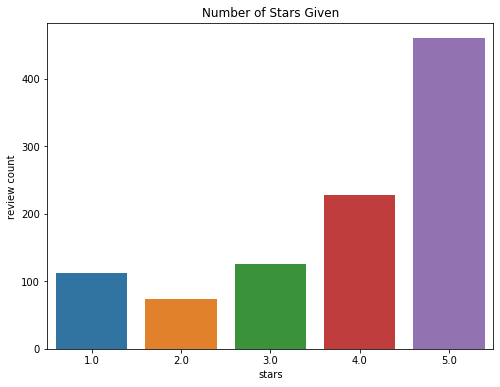

In [169]:
data = data.drop(['business_id', 'review_id', 'user_id'], axis = 1)
fig,ax= plt.subplots(figsize=(8,6))
cplot = sns.countplot(x = "stars", data = data)
cplot.set_title("Number of Stars Given")
cplot.set_ylabel("review count")

Looks like our data is left-skewed; most common value of stars is 5

#### Plot number of reviews by year

Text(0.5, 1.0, 'Reviews by Year')

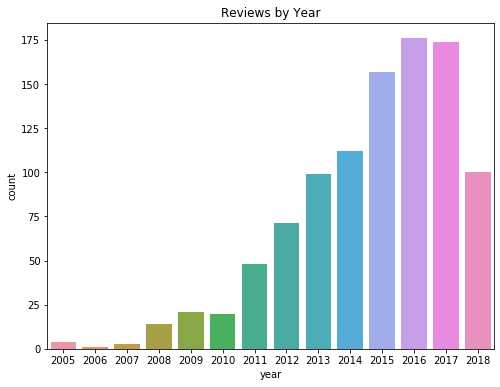

In [170]:
data['year'] = data['date'].str[:4]

fig,ax= plt.subplots(figsize=(8,6))
sns.countplot(x = data['year'] )

plt.title("Reviews by Year")

#### Calc the average review length annd plot its distribution

Mean text length: 568.776 characters
Median text length: 413.0 characters



Text(0.5, 1.0, 'Text Length Distribution')

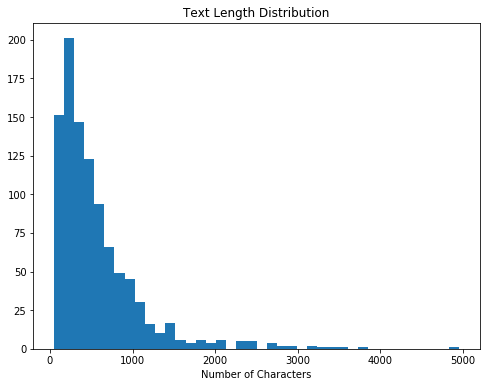

In [171]:
data['text length'] = data['text'].apply(len)

# calc mean and median of review length
print(f"Mean text length: {data['text length'].mean()} characters")
print(f"Median text length: {data['text length'].median()} characters\n")

# plot review length distribution
fig = plt.figure(figsize=(8, 6))
plt.hist(data['text length'], density = False, bins=40)  
plt.xlabel('Number of Characters')
plt.title("Text Length Distribution")

#### Word Cloud of 5-star reviews

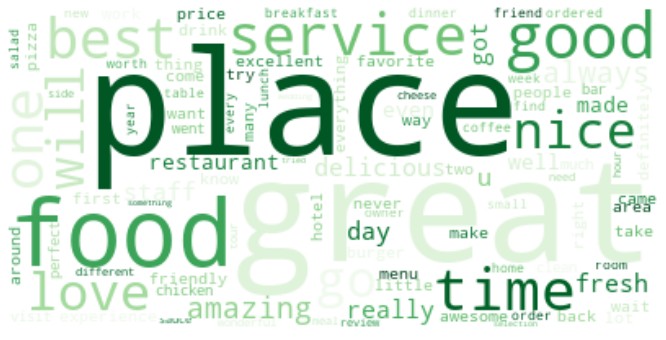

In [172]:
# extract text of five-star reviews
five_star_reviews = data[reviews.stars == 5]
five_star_reviews = five_star_reviews['text']
text = " ".join(i for i in five_star_reviews)

# produce wordcloud
cloud = WordCloud(background_color="white", max_words=100, contour_width = 3, colormap = 'Greens')
cloud.generate(text)

# plot results
plt.figure(figsize=(12,6))
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Word Cloud of 1-star reviews

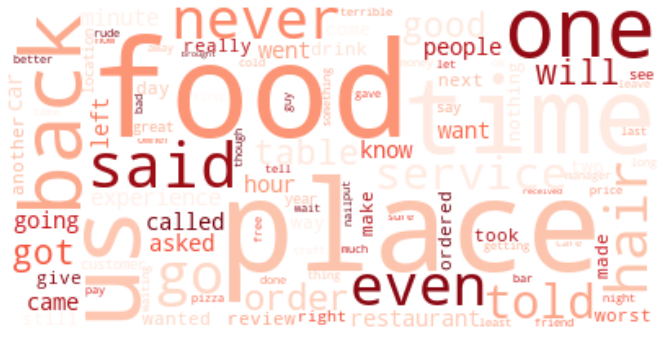

In [173]:
# extract text of one-star reviews
one_star_reviews = reviews[reviews.stars == 1]
one_star_reviews = one_star_reviews['text']
text = " ".join(i for i in one_star_reviews)

# produce wordcloud
cloud = WordCloud(background_color="white", max_words=100, contour_width = 3, colormap = 'Reds')
cloud.generate(text)

# plot results
plt.figure(figsize=(12,6))
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Data Cleaning

#### Look at a quick summary of our data

In [174]:
data.head()

,stars,useful,funny,cool,text,date,year,text length
0,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,2018,513
1,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,2012,829
2,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,2014,339
3,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,2015,243
4,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,2017,534


#### Check for empty values

In [175]:
data.isnull().any().any()

False

No null values in our data

#### Remove any non-English reviews

In [176]:
def return_lang(s):
    return detect(s)

data['language'] = data.text.apply(return_lang)
print(data['language'].value_counts())

cleaned_data = data[data.language == "en"]
print(cleaned_data)

en    999
es      1
Name: language, dtype: int64
     stars  useful  funny  cool  \
0      3.0       0      0     0   
1      5.0       1      0     1   
2      3.0       0      0     0   
3      5.0       1      0     1   
4      4.0       1      0     1   
..     ...     ...    ...   ...   
995    5.0       0      0     0   
996    4.0       1      0     1   
997    5.0       1      0     0   
998    5.0       7      1     0   
999    4.0       0      0     0   

                                                  text                 date  \
0    If you decide to eat here, just be aware it is...  2018-07-07 22:09:11   
1    I've taken a lot of spin classes over the year...  2012-01-03 15:28:18   
2    Family diner. Had the buffet. Eclectic assortm...  2014-02-05 20:30:30   
3    Wow!  Yummy, different,  delicious.   Our favo...  2015-01-04 00:01:03   
4    Cute interior and owner (?) gave us tour of up...  2017-01-14 20:54:15   
..                                                 ...  

#### Extract stars and text since those are the only columns we need for this analysis

In [177]:
cleaned_data = cleaned_data[["stars", "text"]]
cleaned_data.head()

,stars,text
0,3.0,"If you decide to eat here, just be aware it is..."
1,5.0,I've taken a lot of spin classes over the year...
2,3.0,Family diner. Had the buffet. Eclectic assortm...
3,5.0,"Wow! Yummy, different, delicious. Our favo..."
4,4.0,Cute interior and owner (?) gave us tour of up...


#### Add a column called "sentiment" that is "positive" if a review has 4 or 5 stars and "negative" if it has 1 or 2. I'm ignoring 3-star reviews since they likely have both positive and negative sentiment
(Note that removing 3-star reviews reduces our data to ~88.5k reviews)

In [178]:
# removes reviews with 3 stars
cleaned_data = cleaned_data[cleaned_data.stars != 3]

# creates new column "sentiment" that gives us our sentiment
cleaned_data['sentiment'] = np.where(cleaned_data['stars'] == 5 , "positive", np.where(cleaned_data['stars'] == 4 , "positive", "negative"))
print(cleaned_data)

     stars                                               text sentiment
1      5.0  I've taken a lot of spin classes over the year...  positive
3      5.0  Wow!  Yummy, different,  delicious.   Our favo...  positive
4      4.0  Cute interior and owner (?) gave us tour of up...  positive
5      1.0  I am a long term frequent customer of this est...  negative
6      5.0  Loved this tour! I grabbed a groupon and the p...  positive
..     ...                                                ...       ...
995    5.0  I Recently vacationed in St. Petersburg with m...  positive
996    4.0  Very cool bar attached to the Alexander Hotel....  positive
997    5.0  This hotel is a gem in the heart of Philadelph...  positive
998    5.0  Was taken here today by a Colombian friend who...  positive
999    4.0  My friends and I all got one of each that were...  positive

[873 rows x 3 columns]


#### Convert letters to lowercase and remove punctuation

In [179]:
# converts reviews to lowercase
cleaned_data['text'] = cleaned_data['text'].str.lower()

# removes punctuation via "re"
cleaned_data['text'] = cleaned_data['text'].str.replace(r'[^\w\s]+', '')

#### Remove stopwords

In [180]:
stop = stopwords.words("english")

# I noticed a few of the stop words have punctuation that should be removed 
stop = [''.join(c for c in s if c not in string.punctuation) for s in stop]

# Removes stop words for all reviews
cleaned_data['text'] = cleaned_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Models

#### Define x as the text of the reviews and y as the sentiment

In [181]:
x = cleaned_data['text']
y = cleaned_data['sentiment']
print(x)

1      ive taken lot spin classes years nothing compa...
3      wow yummy different delicious favorite lamb cu...
4      cute interior owner gave us tour upcoming pati...
5      long term frequent customer establishment went...
6      loved tour grabbed groupon price great perfect...
                             ...                        
995    recently vacationed st petersburg family doone...
996    cool bar attached alexander hotel several vint...
997    hotel gem heart philadelphia cozy quaint charm...
998    taken today colombian friend needed satisfy cr...
999    friends got one available try love many fun do...
Name: text, Length: 873, dtype: object


#### Use CountVectorizer() to tokenize the text

In [182]:
cv = CountVectorizer().fit(x)
x = cv.transform(x)

#### Create training and test sets using 80/20 split

In [183]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 55)

#### Print out the shapes of the sets to make sure everythink looks right

In [184]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (698, 7924)
y_train shape: (698,)
x_test shape: (175, 7924)
y_test shape: (175,)


## Logistic Regression

First, I will iterate through different values of C to find the optimal value

In [185]:
warnings.filterwarnings("ignore")
c_values = [0.001, 0.010, 0.1, 1, 10, 100, 1000]
lr_train_accs_list = []
lr_test_accs_list = []

# takes quite a bit of time to iterate through this
for i in c_values:
    lr = LogisticRegression(C = i, solver = 'sag').fit(x_train, y_train)
    lr_train_pred = lr.predict(x_train)
    lr_test_pred = lr.predict(x_test)
    lr_train_accs_list.append(round(accuracy_score(y_train,lr_train_pred), 3))
    lr_test_accs_list.append(round(accuracy_score(y_test,lr_test_pred), 3))
print(c_values)
print(lr_train_accs_list)
print(lr_test_accs_list)

[0.001, 0.01, 0.1, 1, 10, 100, 1000]
[0.795, 0.913, 0.986, 0.993, 0.993, 0.993, 0.993]
[0.777, 0.834, 0.874, 0.874, 0.869, 0.869, 0.869]


It looks like 100 performs the best, so I will use that value

In [186]:
warnings.filterwarnings("ignore")

# Fit model
lr = LogisticRegression(C = 100, solver='sag').fit(x_train,y_train)

# Make predictions
lr_train_pred = lr.predict(x_train)
lr_test_pred = lr.predict(x_test)

# Calc accuracies
lr_train_acc = accuracy_score(y_train, lr_train_pred)
lr_test_acc = accuracy_score(y_test,lr_test_pred)

# Output the accuracies
print(f"Accuracy on training set: {lr_train_acc}")
print(f"Accuracy on test set: {lr_test_acc}\n\n")

# Output the confusion matrix
print(f"Confusion Matrix: \n{confusion_matrix(y_test,lr_test_pred)}\n\n")

# Output the classification report
print(f"Classification Report: \n{classification_report(y_test,lr_test_pred)}")

Accuracy on training set: 0.9928366762177651
Accuracy on test set: 0.8685714285714285


Confusion Matrix: 
[[ 21  18]
 [  5 131]]


Classification Report: 
              precision    recall  f1-score   support

    negative       0.81      0.54      0.65        39
    positive       0.88      0.96      0.92       136

    accuracy                           0.87       175
   macro avg       0.84      0.75      0.78       175
weighted avg       0.86      0.87      0.86       175



## Naive Bayes

#### Using multinomial as it is best suited for text classification

In [187]:
# Fit model
nb = MultinomialNB()
nb.fit(x_train, y_train)

# Make predictions
nb_train_pred = nb.predict(x_train)
nb_test_pred = nb.predict(x_test)

# Calc accuracies
nb_train_acc = accuracy_score(y_train, nb_train_pred)
nb_test_acc = accuracy_score(y_test, nb_test_pred)

# Output accuracies
print(f"Accuracy on training set: {nb_train_acc}")
print(f"Accuracy on test set: {nb_test_acc}\n\n")

# Output the confusion matrix
print(f"Confusion Matrix: \n{confusion_matrix(y_test, nb_test_pred)}\n\n")

# Output the classification report
print(f"Classification Report: \n{classification_report(y_test, nb_test_pred)}")

Accuracy on training set: 0.9856733524355301
Accuracy on test set: 0.8628571428571429


Confusion Matrix: 
[[ 24  15]
 [  9 127]]


Classification Report: 
              precision    recall  f1-score   support

    negative       0.73      0.62      0.67        39
    positive       0.89      0.93      0.91       136

    accuracy                           0.86       175
   macro avg       0.81      0.77      0.79       175
weighted avg       0.86      0.86      0.86       175



## K-Nearest Neighbor

#### First, I will plot an elbow graph to find the optimal # of neighbors

In [188]:
errors = []
k_values = list(range(1, 16))
# takes some time to iterate through this
for i in k_values:
    knn_mod = KNeighborsClassifier(n_neighbors = i).fit(x_train,y_train)
    pred_i = knn_mod.predict(x_test)
    errors.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

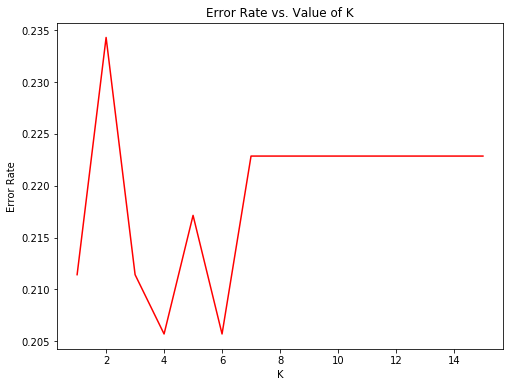

In [189]:
plt.figure(figsize=(8,6))
plt.plot(k_values,errors,color= "red")
plt.title("Error Rate vs. Value of K")
plt.xlabel("K")
plt.ylabel("Error Rate")


Looks like k=4 does a good job, so I will choose that value

In [190]:
# Fit model
neigh = KNeighborsClassifier(n_neighbors = 4).fit(x_train,y_train)

# Make predictions
knn_train_pred = neigh.predict(x_train)
knn_test_pred = neigh.predict(x_test)

# Calc accuracies
knn_train_acc = accuracy_score(y_train,knn_train_pred)
knn_test_acc = accuracy_score(y_test,knn_test_pred)

# Output accuracies
print(f"Accuracy on training set: {knn_train_acc}")
print(f"Accuracy on test set: {knn_test_acc}\n\n")

# Output the confusion matrix
print(f"Confusion Matrix: \n{confusion_matrix(y_test,knn_test_pred)}\n\n")

# Output the classification report
print(f"Classification Report: \n{classification_report(y_test,knn_test_pred)}")

Accuracy on training set: 0.836676217765043
Accuracy on test set: 0.7942857142857143


Confusion Matrix: 
[[  4  35]
 [  1 135]]


Classification Report: 
              precision    recall  f1-score   support

    negative       0.80      0.10      0.18        39
    positive       0.79      0.99      0.88       136

    accuracy                           0.79       175
   macro avg       0.80      0.55      0.53       175
weighted avg       0.80      0.79      0.73       175



## Decision Tree

In [191]:
# Fit model
dt  = DecisionTreeClassifier(criterion = "entropy")
dt.fit(x_train,y_train)

# Make predictions
dt_train_pred = dt.predict(x_train)
dt_test_pred = dt.predict(x_test)

# Calc accuracies
dt_train_acc = accuracy_score(y_train,dt_train_pred)
dt_test_acc = accuracy_score(y_test,dt_test_pred)

# Output the accuracies
print(f"Accuracy on training set: {dt_train_acc}")
print(f"Accuracy on test set: {dt_test_acc}\n\n")

# Output the confusion matrix
print(f"Confusion Matrix: \n{confusion_matrix(y_test,dt_test_pred)}\n\n")

# Output the classification report
print(f"Classification Report: \n{classification_report(y_test,dt_test_pred)}")

Accuracy on training set: 1.0
Accuracy on test set: 0.8114285714285714


Confusion Matrix: 
[[ 19  20]
 [ 13 123]]


Classification Report: 
              precision    recall  f1-score   support

    negative       0.59      0.49      0.54        39
    positive       0.86      0.90      0.88       136

    accuracy                           0.81       175
   macro avg       0.73      0.70      0.71       175
weighted avg       0.80      0.81      0.80       175



## Random Forest

#### First I want to find the optimal number of n_estimators

In [192]:
dt_train=[]
dt_test=[]
depth=[]
# takes quite a bit of time to iterate through this
for i in range(1,25):
    my_random_forest = RandomForestClassifier(n_estimators=i,random_state=1)
    my_random_forest.fit(x_train, y_train)
    dt_train.append(my_random_forest.score(x_train, y_train))
    dt_test.append(my_random_forest.score(x_test, y_test))
    depth.append(i)

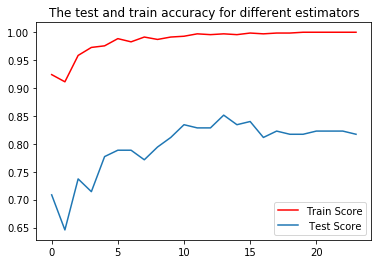

Optimal estimators: 20


In [193]:
plt.figure()
plt.title('The test and train accuracy for different estimators')
plt.plot(dt_train,color='red',label='Train Score')
plt.plot(dt_test,label=' Test Score')
plt.legend()
plt.show()
optimal_estimators = depth[np.argmax(dt_test)]
print(f"Optimal estimators: {depth[np.argmax(dt_train)]}")


#### Although I plotted this model on both the training and test data, the "optimal_estimators" value is based on the training data results only; therefore, goal seeking is avoided. Ultimately, the optimal # is found to be ____

In [194]:
# Fit model
rf = RandomForestClassifier(n_estimators = optimal_estimators, criterion = "entropy").fit(x_train,y_train)

# Make predictions
rf_train_pred = rf.predict(x_train)
rf_test_pred = rf.predict(x_test)

# Calc accuracies
rf_train_acc = accuracy_score(y_train,rf_train_pred)
rf_test_acc = accuracy_score(y_test,rf_test_pred)

# Output accuracies
print(f"Accuracy on training set: {rf_train_acc}")
print(f"Accuracy on test set: {rf_test_acc}\n\n")

# Output the confusion matrix
print(f"Confusion Matrix: \n{confusion_matrix(y_test,rf_test_pred)}\n\n")

# Output the classification report
print(f"Classification Report: \n{classification_report(y_test,rf_test_pred)}")

Accuracy on training set: 0.997134670487106
Accuracy on test set: 0.8514285714285714


Confusion Matrix: 
[[ 18  21]
 [  5 131]]


Classification Report: 
              precision    recall  f1-score   support

    negative       0.78      0.46      0.58        39
    positive       0.86      0.96      0.91       136

    accuracy                           0.85       175
   macro avg       0.82      0.71      0.75       175
weighted avg       0.84      0.85      0.84       175



## Plotting Accuracies by Model

#### Plot accuracies from highest to lowest

Text(0.5, 1.0, 'Accuracy by Model')

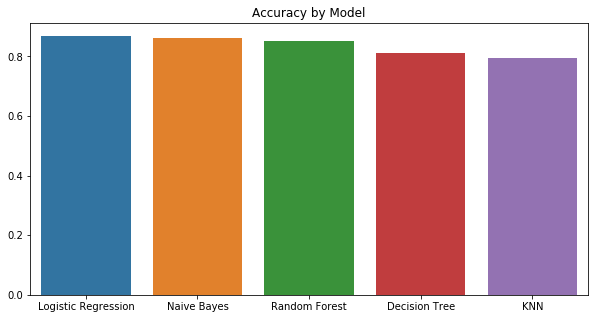

In [195]:
# sort the accuracies from highest to lowest and prep it to be plotted
models_and_accs = {"Logistic Regression": lr_test_acc, "Naive Bayes": nb_test_acc, "KNN": knn_test_acc, "Decision Tree": dt_test_acc, "Random Forest": rf_test_acc}
models_and_accs_tups = sorted(models_and_accs.items(), key=lambda x:x[1], reverse = True)
models, accs = [list(tup) for tup in zip(*models_and_accs_tups)]

# plot the sorted accuracies 
plt.figure(figsize = (10,5))
acc_plot = sns.barplot(models, accs)
acc_plot.set_title('Accuracy by Model')